## IMPORTING NECESSARY LIBRARIES
Go through this for understanding the workflow: https://www.notion.so/STOCK-SENTIMENT-ANALYSIS-USING-MACHINE-LEARNING-eead714b26754c0a9d7a961713cd68ae?pvs=4

In [4]:

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go


SMALL ANALYSIS OF STOCKS DATA

In [5]:
amzn = yf.Ticker("AMZN")
hist = amzn.history(period="10Y")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-06-16 00:00:00-04:00,16.243000,16.434500,16.176001,16.381001,48996000,0.0,0.0
2014-06-17 00:00:00-04:00,16.377001,16.566999,16.261499,16.281000,58482000,0.0,0.0
2014-06-18 00:00:00-04:00,16.400000,16.787500,16.250000,16.719000,128030000,0.0,0.0
2014-06-19 00:00:00-04:00,16.763000,16.945000,16.299000,16.350000,106412000,0.0,0.0
2014-06-20 00:00:00-04:00,16.388000,16.410999,16.021000,16.209999,121080000,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-07 00:00:00-04:00,184.899994,186.289993,183.360001,184.300003,28021500,0.0,0.0
2024-06-10 00:00:00-04:00,184.070007,187.229996,183.789993,187.059998,34494500,0.0,0.0
2024-06-11 00:00:00-04:00,187.059998,187.770004,184.539993,187.229996,27265100,0.0,0.0


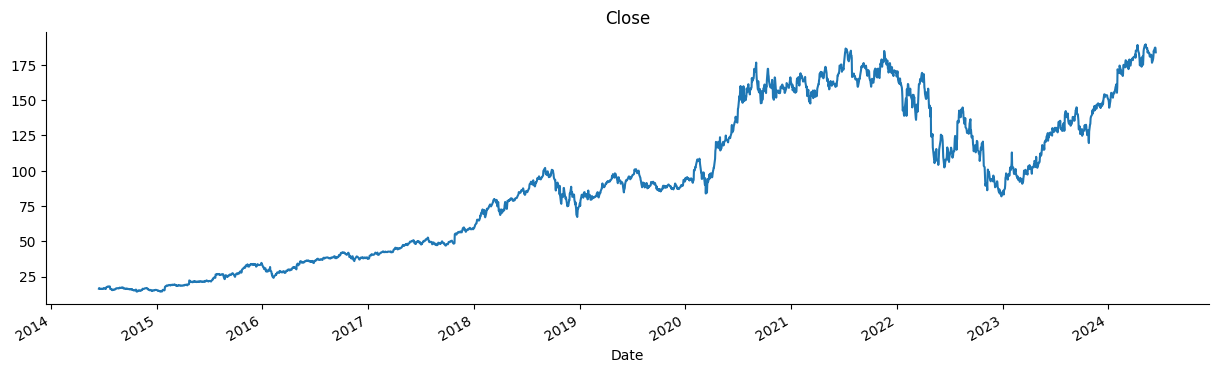

In [6]:

from matplotlib import pyplot as plt
hist['Close'].plot(kind='line', figsize=(15, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

# STOCKS CHOSEN FOR TRAINING - AMAZON , NVIDIA ,TESLA

In [7]:
stonks = [
    "TSLA",
    "AMZN",
    "NVDA"
]
hists = {}
for s in stonks:
    tkr = yf.Ticker(s)
    history = tkr.history(period="5y")
    hists[s] = history

for stock in stonks:
    temp_df = hists[stock].copy()

    fig = go.Figure(
        data=[
            go.Candlestick(
                x=temp_df.index,
                open=temp_df["Open"],
                high=temp_df["High"],
                low=temp_df["Low"],
                close=temp_df["Close"],
            )
        ]
    )

    fig.update_layout(
        margin=dict(l=20, r=20, t=60, b=20),
        height=300,
        paper_bgcolor="LightSteelBlue",
        title=stock,
    )

    fig.show()

# First main task -
## Web scrapping stock data via Selenium

In [10]:
!pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.7/467.7 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00


In [11]:
!apt-get update
!apt-get install chromium chromium-driver

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,910 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,391 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/unive

In [8]:
def web_driver():
    options = webdriver.ChromeOptions()
    options.add_argument("--verbose")
    options.add_argument('--no-sandbox')
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    options.add_argument("--window-size=1920, 1200")
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver


In [13]:
import pandas as pd
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = web_driver()


titles = []
dates = []
driver.get("https://www.ft.com/search?q=amazon&contentType=article&sort=relevance")
time.sleep(2)

articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
for article in articles:
    # Find title and date elements within each article
    title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
    date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

    # Extract text from title and date elements
    title = title_element.text
    date = date_element.text

    # Append title and date to respective lists
    titles.append(title)
    dates.append(date)
# time.sleep(3)
# driver.quit()
print("PAGE 1"+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")


driver.get("https://www.ft.com/search?q=amazon&page=2&contentType=article&sort=relevance&isFirstView=false")
time.sleep(2)
articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
for article in articles:
    # Find title and date elements within each article
    title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
    date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

    # Extract text from title and date elements
    title = title_element.text
    date = date_element.text

    # Append title and date to respective lists
    titles.append(title)
    dates.append(date)

# time.sleep(3)
print("PAGE 2"+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")

# driver.quit()
pagect = 3
# driver.get("https://www.ft.com/search?q=amazon&page="+str(pagect)+"&sort=relevance&isFirstView=false")
while pagect < 800:
    driver.get("https://www.ft.com/search?q=amazon&page=" +str(pagect) + "&contentType=article&sort=relevance&isFirstView=false")
    time.sleep(2)

    articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
    for article in articles:
        # Find title and date elements within each article
        title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
        date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

        # Extract text from title and date elements
        title = title_element.text
        date = date_element.text
        print(date)
        # Append title and date to respective lists
        titles.append(title)
        dates.append(date)

    print("PAGE " + str(pagect)+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    pagect+= 1




PAGE 1 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
PAGE 2 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
JANUARY 15, 2024
JUNE 13, 2024
JANUARY 31, 2024
FEBRUARY 5, 2024
NOVEMBER 8, 2023
NOVEMBER 27, 2023
OCTOBER 23, 2023
JANUARY 8, 2024
JUNE 6, 2024
SEPTEMBER 27, 2023
MAY 23, 2024
MARCH 2, 2024
OCTOBER 11, 2023
SEPTEMBER 25, 2023
SEPTEMBER 25, 2023
JUNE 10, 2024
OCTOBER 26, 2023
NOVEMBER 2, 2023
JUNE 13, 2024
OCTOBER 5, 2023
SEPTEMBER 30, 2023
DECEMBER 15, 2023
FEBRUARY 14, 2024
MAY 2, 2024
MAY 21, 2024
PAGE 3 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
MAY 2, 2024
MAY 1, 2024
NOVEMBER 6, 2023
APRIL 22, 2024
JUNE 10, 2024
SEPTEMBER 27, 2023
MAY 21, 2024
MAY 30, 2024
SEPTEMBER 27, 2023
SEPTEMBER 27, 2023
JANUARY 30, 2024
MARCH 24, 2024
APRIL 18, 2024
APRIL 26, 2024
DECEMBER 7, 2023
JUNE 6, 2024
MAY 11, 2024
FEBRUARY 15, 2024
SEPTEMBER 20, 2023
APRIL 26, 2024
JUNE 10, 2024
FEBRUARY 11, 2024
SEPTEMBER 25, 2023
FEBRUARY 19, 2024
JUNE 11, 202

KeyboardInterrupt: 

In [14]:
month_mapping = {
    'JANUARY': '01', 'FEBRUARY': '02', 'MARCH': '03', 'APRIL': '04',
    'MAY': '05', 'JUNE': '06', 'JULY': '07', 'AUGUST': '08',
    'SEPTEMBER': '09', 'OCTOBER': '10', 'NOVEMBER': '11', 'DECEMBER': '12'
}
def convert_date(date_str):
    parts = date_str.split()
    month = month_mapping[parts[0].upper()]
    day = parts[1][:-1]  # Remove the comma from the day part
    year = parts[2]
    return f"{year}-{month}-{day}"

In [15]:
data = {'Date': dates,'Title': titles}
df = pd.DataFrame(data)
df.head()
df['Date'] = df['Date'].apply(convert_date)

# Convert the 'Date' column to pandas datetime object
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame based on the 'Date' column in descending order
df_sorted = df.sort_values(by='Date', ascending=True)
df_sorted.to_csv('sorteddataframe',encoding='utf-8',index=False)
finaldf= pd.read_csv('sorteddataframe')
finaldf
df_concatenated = finaldf.groupby('Date')['Title'].agg(lambda x: ', '.join(x)).reset_index()
df_concatenated.head()

,Date,Title
0,2022-07-27,Is Amazon cheap? Premium\n content
1,2022-09-14,Amazon sued by California over ‘anti-competiti...
2,2022-09-20,Companies that buy Amazon marketplace sellers ...
3,2022-09-21,Colombia’s battle against Amazon deforestation...
4,2022-09-27,Amazon: Prime Day II is an attempt to fill up ...


In [16]:
hist['Label'] = (hist['Close'].shift(-1) - hist['Close'] > 0).astype(int)
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label
Date,,,,,,,,
2014-06-16 00:00:00-04:00,16.243000,16.434500,16.176001,16.381001,48996000,0.0,0.0,0
2014-06-17 00:00:00-04:00,16.377001,16.566999,16.261499,16.281000,58482000,0.0,0.0,1
2014-06-18 00:00:00-04:00,16.400000,16.787500,16.250000,16.719000,128030000,0.0,0.0,0
2014-06-19 00:00:00-04:00,16.763000,16.945000,16.299000,16.350000,106412000,0.0,0.0,0
2014-06-20 00:00:00-04:00,16.388000,16.410999,16.021000,16.209999,121080000,0.0,0.0,1
...,...,...,...,...,...,...,...,...
2024-06-07 00:00:00-04:00,184.899994,186.289993,183.360001,184.300003,28021500,0.0,0.0,1
2024-06-10 00:00:00-04:00,184.070007,187.229996,183.789993,187.059998,34494500,0.0,0.0,1
2024-06-11 00:00:00-04:00,187.059998,187.770004,184.539993,187.229996,27265100,0.0,0.0,0


In [17]:
# Create an empty list to store labels
labels = []
hist.index= hist.index.date
# Iterate over each row in the DataFrame
for index, row in df_concatenated.iterrows():
    # Get the date from the current row
    date_str = row['Date']
    date = pd.to_datetime(date_str).date()

    # Find the label based on the date
    if date in hist.index:
        label = hist.loc[date, 'Label']
    else:
        label = None

    # Append the label to the list
    labels.append(label)

# Assign the labels list to the 'Label' column in df_concatenated
df_concatenated['Label'] = labels

# Convert the 'Label' column to integer type
df_concatenated['Label'] = df_concatenated['Label'].astype('Int64')

# Display the DataFrame with the new 'Label' column
print(df_concatenated)


           Date                                              Title  Label
0    2022-07-27                 Is Amazon cheap? Premium\n content      1
1    2022-09-14  Amazon sued by California over ‘anti-competiti...      0
2    2022-09-20  Companies that buy Amazon marketplace sellers ...      0
3    2022-09-21  Colombia’s battle against Amazon deforestation...      0
4    2022-09-27  Amazon: Prime Day II is an attempt to fill up ...      1
..          ...                                                ...    ...
368  2024-06-10  Edgar Bronfman Jr joins billionaires circling ...      1
369  2024-06-11  Transcript: The Five Minute Investor from Mone...      0
370  2024-06-12  Hydrogen industry calls for more support to ac...      0
371  2024-06-13  Europe’s unified patent court draws companies ...      0
372  2024-06-14                             FTAV’s further reading   <NA>

[373 rows x 3 columns]


In [18]:
df_concatenated = df_concatenated.dropna(subset=['Label'])
df_concatenated = df_concatenated.reset_index(drop=True)

print(df_concatenated)

           Date                                              Title  Label
0    2022-07-27                 Is Amazon cheap? Premium\n content      1
1    2022-09-14  Amazon sued by California over ‘anti-competiti...      0
2    2022-09-20  Companies that buy Amazon marketplace sellers ...      0
3    2022-09-21  Colombia’s battle against Amazon deforestation...      0
4    2022-09-27  Amazon: Prime Day II is an attempt to fill up ...      1
..          ...                                                ...    ...
294  2024-06-07  Hot jobs report suggests US rates could stay h...      1
295  2024-06-10  Edgar Bronfman Jr joins billionaires circling ...      1
296  2024-06-11  Transcript: The Five Minute Investor from Mone...      0
297  2024-06-12  Hydrogen industry calls for more support to ac...      0
298  2024-06-13  Europe’s unified patent court draws companies ...      0

[299 rows x 3 columns]


In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
# Import NLTK libraries
stop_words = stopwords.words('english')
ps = PorterStemmer()

# Clean the text data
df_concatenated['text_cleaned'] = df_concatenated['Title'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
df_concatenated.head()

,Date,Title,Label,text_cleaned
0,2022-07-27,Is Amazon cheap? Premium\n content,1,is amazon cheap? premium content
1,2022-09-14,Amazon sued by California over ‘anti-competiti...,0,amazon su california ‘anti-competitive’ price ...
2,2022-09-20,Companies that buy Amazon marketplace sellers ...,0,compani buy amazon marketplac seller suffer de...
3,2022-09-21,Colombia’s battle against Amazon deforestation...,0,colombia’ battl amazon deforestation: ‘the jun...
4,2022-09-27,Amazon: Prime Day II is an attempt to fill up ...,1,amazon: prime day ii attempt fill empti wareho...


In [21]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# # Apply TF-IDF vectorization
# vectorizer = TfidfVectorizer()
# features = vectorizer.fit_transform(df_concatenated['text_cleaned'])

In [23]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Make sure to download Vader lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the Sentiment Intensity Analyzer
sid = SentimentIntensityAnalyzer()

# Apply the sentiment analyzer to each Title in the DataFrame
df_concatenated['compound'] = df_concatenated['text_cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])

print(df_concatenated)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


           Date                                              Title  Label  \
0    2022-07-27                 Is Amazon cheap? Premium\n content      1   
1    2022-09-14  Amazon sued by California over ‘anti-competiti...      0   
2    2022-09-20  Companies that buy Amazon marketplace sellers ...      0   
3    2022-09-21  Colombia’s battle against Amazon deforestation...      0   
4    2022-09-27  Amazon: Prime Day II is an attempt to fill up ...      1   
..          ...                                                ...    ...   
294  2024-06-07  Hot jobs report suggests US rates could stay h...      1   
295  2024-06-10  Edgar Bronfman Jr joins billionaires circling ...      1   
296  2024-06-11  Transcript: The Five Minute Investor from Mone...      0   
297  2024-06-12  Hydrogen industry calls for more support to ac...      0   
298  2024-06-13  Europe’s unified patent court draws companies ...      0   

                                          text_cleaned  compound  
0       

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Features (compound score)
X = df_concatenated[['compound']]

# Target variable (label)
y = df_concatenated['Label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=81)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=93)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
class_report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.7666666666666667
Confusion Matrix:
[[10  6]
 [ 1 13]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.62      0.74        16
         1.0       0.68      0.93      0.79        14

    accuracy                           0.77        30
   macro avg       0.80      0.78      0.76        30
weighted avg       0.80      0.77      0.76        30



In [25]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

best_accuracy = 0
best_combination = None

# Features (compound score)
features = df_concatenated[['compound']]

for random_state_rf in range(80, 101):
    for random_state_split in range(80, 101):
        for test_size in np.arange(0.1, 0.21, 0.1):
            X_train, X_test, y_train, y_test = train_test_split(features, df_concatenated['Label'], test_size=test_size, random_state=random_state_split)
            rf_classifier = RandomForestClassifier(random_state=random_state_rf)
            rf_classifier.fit(X_train, y_train)
            y_pred = rf_classifier.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_combination = (random_state_rf, random_state_split, test_size)

print("Best accuracy:", best_accuracy)
print("Best combination (random_state_rf, random_state_split, test_size):", best_combination)


Best accuracy: 0.7666666666666667
Best combination (random_state_rf, random_state_split, test_size): (93, 81, 0.1)


## **NOW THE MODEL IS READY FOR USE : FEED SENTIMENT - GET THE LABEL OF INCREASE / DECREASE**\

In [27]:
apple = yf.Ticker("AAPL")
apdf = apple.history(period="2y")
apdf

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-14 00:00:00-04:00,131.819202,132.571714,130.185439,131.452835,84784300,0.0,0.0
2022-06-15 00:00:00-04:00,132.967783,135.987756,130.858765,134.096558,91533000,0.0,0.0
2022-06-16 00:00:00-04:00,130.779550,131.086495,127.769473,128.779434,108123900,0.0,0.0
2022-06-17 00:00:00-04:00,128.789344,131.769702,128.531894,130.264664,134520300,0.0,0.0
2022-06-21 00:00:00-04:00,132.106352,135.710512,132.007346,134.532227,81000500,0.0,0.0
...,...,...,...,...,...,...,...
2024-06-07 00:00:00-04:00,194.649994,196.940002,194.139999,196.889999,53103900,0.0,0.0
2024-06-10 00:00:00-04:00,196.899994,197.300003,192.149994,193.119995,97262100,0.0,0.0
2024-06-11 00:00:00-04:00,193.649994,207.160004,193.630005,207.149994,172373300,0.0,0.0


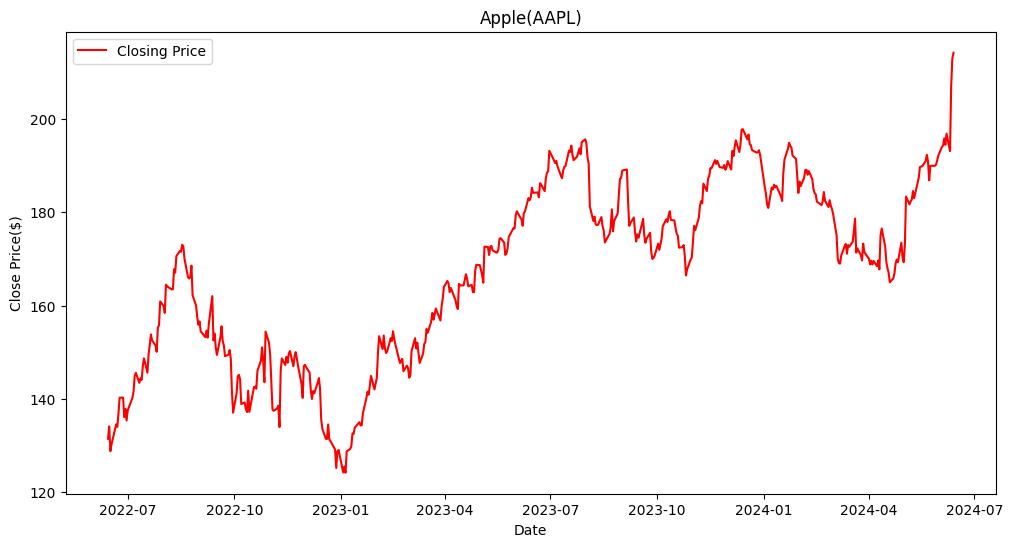

In [28]:
#Visual Representation of closing price vs Date
plt.figure(figsize=(12,6))
plt.plot(apdf['Close'],label='Closing Price',c='r',alpha=1)
plt.title('Apple(AAPL)')
plt.ylabel('Close Price($)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

In [29]:
driver= web_driver()
testtitles = []
testdates = []
driver.get("https://www.ft.com/search?q=apple&contentType=article&sort=relevance")
time.sleep(2)

articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
for article in articles:
    # Find title and date elements within each article
    title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
    date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

    # Extract text from title and date elements
    title = title_element.text
    date = date_element.text

    # Append title and date to respective lists
    testtitles.append(title)
    testdates.append(date)
# time.sleep(3)
# driver.quit()
print("PAGE 1"+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")


driver.get("https://www.ft.com/search?q=apple&page=2&contentType=article&sort=relevance&isFirstView=false")
time.sleep(2)
articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
for article in articles:
    # Find title and date elements within each article
    title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
    date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

    # Extract text from title and date elements
    title = title_element.text
    date = date_element.text

    # Append title and date to respective lists
    testtitles.append(title)
    testdates.append(date)

# time.sleep(3)
print("PAGE 2"+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")

# driver.quit()
pagect = 3
# driver.get("https://www.ft.com/search?q=amazon&page="+str(pagect)+"&sort=relevance&isFirstView=false")
while pagect < 800:
    driver.get("https://www.ft.com/search?q=apple&page=" +str(pagect) + "&contentType=article&sort=relevance&isFirstView=false")
    time.sleep(2)

    articles = driver.find_elements(By.CLASS_NAME, "o-teaser__content")
    for article in articles:
        # Find title and date elements within each article
        title_element = article.find_element(By.CLASS_NAME, "o-teaser__heading")
        date_element = article.find_element(By.CLASS_NAME, "o-teaser__timestamp")

        # Extract text from title and date elements
        title = title_element.text
        date = date_element.text
        print(date)
        # Append title and date to respective lists
        testtitles.append(title)
        testdates.append(date)

    print("PAGE " + str(pagect)+" ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||")
    pagect+= 1




PAGE 1 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
PAGE 2 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
MARCH 1, 2024
MARCH 4, 2024
FEBRUARY 21, 2024
FEBRUARY 27, 2024
MARCH 21, 2024
FEBRUARY 26, 2024
MARCH 12, 2024
MARCH 1, 2024
FEBRUARY 27, 2024
JUNE 14, 2024
FEBRUARY 23, 2024
JUNE 6, 2024
FEBRUARY 18, 2024
JUNE 11, 2024
FEBRUARY 14, 2024
MARCH 19, 2024
FEBRUARY 28, 2024
FEBRUARY 28, 2024
JANUARY 25, 2024
MARCH 4, 2024
JUNE 13, 2024
MARCH 10, 2024
MAY 2, 2024
FEBRUARY 2, 2024
MARCH 11, 2024
PAGE 3 ENDS |||||||||||||||||||||||||||||||||||||||||||||||||||||||
JANUARY 24, 2024
FEBRUARY 2, 2024
FEBRUARY 15, 2024
FEBRUARY 1, 2024
MARCH 29, 2024
JANUARY 22, 2024
MAY 10, 2024
JANUARY 3, 2024
JANUARY 8, 2024
JANUARY 18, 2024
MARCH 6, 2024
MARCH 12, 2024
JANUARY 16, 2024
MAY 28, 2024
DECEMBER 28, 2023
JANUARY 11, 2024
JANUARY 16, 2024
DECEMBER 21, 2023
JANUARY 1, 2024
DECEMBER 15, 2023
JANUARY 25, 2024
MAY 17, 2024
JUNE 7, 2024
DECEMBER 26, 2023
APRIL 30, 2024


KeyboardInterrupt: 

In [30]:
appledata = {'Date': testdates,'Title': testtitles}
appledf = pd.DataFrame(appledata)

appledf['Date'] = appledf['Date'].apply(convert_date)

# Convert the 'Date' column to pandas datetime object
appledf['Date'] = pd.to_datetime(appledf['Date'])

# Sort the DataFrame based on the 'Date' column in descending order
appledf_sorted = appledf.sort_values(by='Date', ascending=True)

appledf_sorted.to_csv('applesorteddataframe',encoding='utf-8',index=False)
applefinaldf= pd.read_csv('applesorteddataframe')
appledf_concatenated = applefinaldf.groupby('Date')['Title'].agg(lambda x: ', '.join(x)).reset_index()
appledf_concatenated


,Date,Title
0,2022-11-09,Goertek/Apple: single-client risk amplifies Ai...
1,2022-12-07,LG/Apple: Korean group should benefit from muc...
2,2022-12-09,Apple to end employee gagging clauses after ac...
3,2022-12-25,Apple’s business under growing threat from Chi...
4,2023-01-03,Apple’s market value falls below $2tn as tech ...
...,...,...
341,2024-06-10,European markets take a hit as Macron calls sn...
342,2024-06-11,Milei pitches Argentina as low-regulation AI h...
343,2024-06-12,"Apple’s belated AI gambit, US regulators have ..."
344,2024-06-13,"Microsoft feels the heat in Europe, Trump prom..."


In [31]:
appledf_concatenated['text_cleaned'] = appledf_concatenated['Title'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() if word not in stop_words]))

In [32]:
appledf_concatenated['compound'] = appledf_concatenated['text_cleaned'].apply(lambda x: sid.polarity_scores(x)['compound'])


In [33]:
appledf_concatenated.head()

,Date,Title,text_cleaned,compound
0,2022-11-09,Goertek/Apple: single-client risk amplifies Ai...,goertek/apple: single-cli risk amplifi airpod ...,-0.5574
1,2022-12-07,LG/Apple: Korean group should benefit from muc...,lg/apple: korean group benefit much-anticip ic...,0.4588
2,2022-12-09,Apple to end employee gagging clauses after ac...,appl end employe gag claus activist campaign,-0.3400
3,2022-12-25,Apple’s business under growing threat from Chi...,apple’ busi grow threat china’ coronaviru wave,-0.5267
4,2023-01-03,Apple’s market value falls below $2tn as tech ...,apple’ market valu fall $2tn tech rout hit iph...,-0.2500


In [34]:
features_apple = appledf_concatenated[['compound']]

# Predict labels using the trained Random Forest Classifier
predicted_labels = rf_classifier.predict(features_apple)

# Assign predicted labels to the 'Label' column in the 'apple' DataFrame
appledf_concatenated['Label'] = predicted_labels

# Display the modified DataFrame with predicted labels
print(appledf_concatenated)

           Date                                              Title  \
0    2022-11-09  Goertek/Apple: single-client risk amplifies Ai...   
1    2022-12-07  LG/Apple: Korean group should benefit from muc...   
2    2022-12-09  Apple to end employee gagging clauses after ac...   
3    2022-12-25  Apple’s business under growing threat from Chi...   
4    2023-01-03  Apple’s market value falls below $2tn as tech ...   
..          ...                                                ...   
341  2024-06-10  European markets take a hit as Macron calls sn...   
342  2024-06-11  Milei pitches Argentina as low-regulation AI h...   
343  2024-06-12  Apple’s belated AI gambit, US regulators have ...   
344  2024-06-13  Microsoft feels the heat in Europe, Trump prom...   
345  2024-06-14  Is a recession worse than inflation?, What I l...   

                                          text_cleaned  compound  Label  
0    goertek/apple: single-cli risk amplifi airpod ...   -0.5574    0.0  
1    lg/app

In [35]:
# Create a new list to store the close prices
close_prices = []

# Loop through each date in appledf_concatenated
for date in appledf_concatenated['Date']:
    # Check if the date exists in apdf
    if date in apdf.index:
        # If the date exists, append the close price to the close_prices list
        close_prices.append(apdf.loc[date, 'Close'])
    else:
        # If the date doesn't exist, append None to indicate missing data
        close_prices.append(None)

# Add the close prices to the appledf_concatenated DataFrame as a new column
appledf_concatenated['Close'] = close_prices
# Remove rows with NaN values in the 'Close' column
appledf_concatenated = appledf_concatenated.dropna(subset=['Close'])

# Reset index after removing rows
appledf_concatenated = appledf_concatenated.reset_index(drop=True)
# Display the DataFrame with the close prices added
print(appledf_concatenated)

           Date                                              Title  \
0    2022-11-09  Goertek/Apple: single-client risk amplifies Ai...   
1    2022-12-07  LG/Apple: Korean group should benefit from muc...   
2    2022-12-09  Apple to end employee gagging clauses after ac...   
3    2023-01-03  Apple’s market value falls below $2tn as tech ...   
4    2023-01-04       Apple and Tesla start 2023 on the wrong foot   
..          ...                                                ...   
266  2024-06-07  Employers seek to ease pressure of fertility t...   
267  2024-06-10  European markets take a hit as Macron calls sn...   
268  2024-06-11  Milei pitches Argentina as low-regulation AI h...   
269  2024-06-12  Apple’s belated AI gambit, US regulators have ...   
270  2024-06-13  Microsoft feels the heat in Europe, Trump prom...   

                                          text_cleaned  compound  Label  \
0    goertek/apple: single-cli risk amplifi airpod ...   -0.5574    0.0   
1    lg/a

NOW IMPLIMENTING THE STRATEGY

In [66]:
def Strategy(data):
    position = False
    sell_price = []
    buy_price = []
    trade = []
    buy_dates = []  # List to store dates of buy signals
    sell_dates = []  # List to store dates of sell signals

    for i in range(len(data)):

        if data['Label'][i] == 0 and position == False:
            position = True
            number = int(investment / data['Close'][i])
            buy_price.append(data['Close'][i])

            c = data['Close'][i]
            buy_dates.append(data['Date'][i])  # Store the date of buy signal

        elif data['Label'][i] == 1 and position == True:
            position = False
            sell_price.append(data['Close'][i])

            trade.append((data['Close'][i] - c) * number)
            sell_dates.append(data['Date'][i])  # Store the date of sell signal

        else:
            pass  # Do nothing - ruko zara , sabar karo , bhot trade karli

    return buy_price, sell_price, trade, buy_dates, sell_dates, position


In [65]:
investment = 100000 # Adjust your investment amount here

buy_prices, sell_prices, trades, buy_dates, sell_dates, position = Strategy(appledf_concatenated)




In [67]:
# Convert sell_dates to datetime objects
sell_dates = pd.to_datetime(sell_dates)
buy_dates = pd.to_datetime(buy_dates)



In [68]:
print("Length of sell_prices:", len(sell_prices))
print("Length of sell_dates:", len(sell_dates))
print("Length of buy_prices:", len(buy_prices))
print("Length of buy_dates:", len(buy_dates))



Length of sell_prices: 65
Length of sell_dates: 65
Length of buy_prices: 65
Length of buy_dates: 65


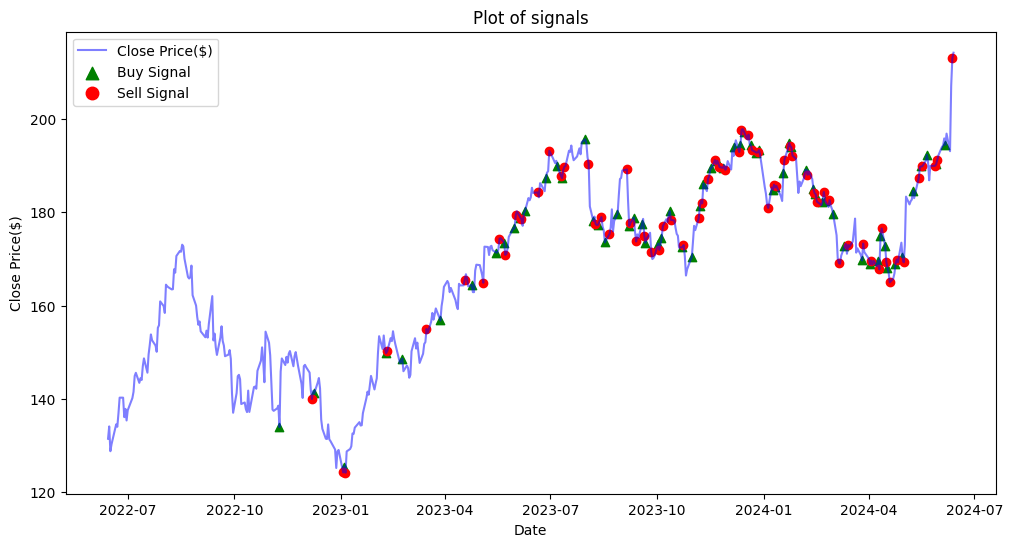

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.title('Plot of signals')
plt.plot(apdf.index, apdf['Close'], label='Close Price($)', c='b', alpha=0.5)

# Mark buy signals
for i in range(len(buy_dates)):
    plt.scatter(x=buy_dates[i], y=buy_prices[i], c='g', marker='^', alpha=1, label='Buy Signal' if i == 0 else None)
for i in range(len(sell_dates)):
    plt.scatter(x=sell_dates[i], y=sell_prices[i], c='r', marker='o', alpha=1, label='Sell Signal' if i == 0 else None)

# Mark sell signals

plt.ylabel('Close Price($)')
plt.xlabel('Date')

# Add legend for scatter points
plt.legend(loc="upper left", markerscale=1.5)

plt.show()


In [70]:
wins=[]
for i in range(len(trades)):
    if(trades[i]>=0):
        wins.append(trades[i])
wins

[4497.30908203125,
 245.4738311767578,
 4311.38818359375,
 5588.533889770508,
 278.18115234375,
 1730.49658203125,
 1601.1073913574219,
 2234.867919921875,
 3137.645492553711,
 1306.0272979736328,
 937.7778015136719,
 1057.0869140625,
 5273.8724365234375,
 348.7650146484375,
 1474.5202331542969,
 254.0988006591797,
 4953.161819458008,
 324.2472229003906,
 557.7717132568359,
 926.3350219726562,
 1668.36669921875,
 51.72412109375,
 566.2765502929688,
 177.6407012939453,
 1550.9147644042969,
 1123.393310546875,
 60.17033386230469,
 144.5,
 2120.3946075439453,
 479.5185546875,
 862.215576171875,
 514.1671142578125,
 1547.2520751953125,
 15.77935791015625,
 525.0,
 9555.26596069336]

In [71]:
losses=[]
for i in range(len(trades)):
    if(trades[i]<=0):
        losses.append(trades[i])
losses

[-12017.126770019531,
 -1059.3616333007812,
 -1514.654296875,
 -206.0084228515625,
 -1084.5298767089844,
 -2687.467330932617,
 -368.7982635498047,
 -2866.2635192871094,
 -1392.6295013427734,
 -1131.78515625,
 -776.9373321533203,
 -1027.7775268554688,
 -699.9242858886719,
 -221.05758666992188,
 -560.640869140625,
 -318.3732604980469,
 -554.3993835449219,
 -6402.631942749023,
 -348.39788818359375,
 -900.1026916503906,
 -574.784912109375,
 -480.59967041015625,
 -841.6516571044922,
 -5860.2447509765625,
 -1113.2096405029297,
 -1916.4885864257812,
 -1785.0,
 -604.6092834472656,
 -1224.840316772461]

In [72]:
#No. of Profitable Trades
number_profit=0
for i in range(0,len(trades)):
    if trades[i]>0:
       number_profit+=1
number_profit

36

In [73]:
#Number of trades in which loss occurs
number_losses=0
for i in range(0,len(trades)):
    if trades[i]<0:
       number_losses+=1
number_losses

29

In [74]:
#Total profits
pft=0
for i in range(0,len(trades)):
    if trades[i]>0:
       pft+=trades[i]
pft

62001.24752807617

In [75]:
#Total Losses
lss=0
for i in range(0,len(trades)):
    if trades[i]<0:
       lss+=trades[i]
lss

-50540.29635620117

In [76]:
#Simple Annualised return
final_return=sum(trades)
annulised_return = (pft+lss)*100/(investment*10)
annulised_return

1.1460951171875

In [77]:
#Final Portfolio Return
portfolio_return=(final_return)*100/investment
print("The return on investment is: ",portfolio_return,"%")

The return on investment is:  11.460951171875 %


In [78]:
#Sharpe Ratio
import statistics
sharpe_ratio = (statistics.mean(trades) + 459.76) / statistics.stdev(trades)
sharpe_ratio

0.22465970521342082

In [79]:
#Calculate Portfolio value
Portfolio_value=[]
value=0
for i in range(len(trades)):
    value+=trades[i]
    Portfolio_value.append(value+investment)
len(Portfolio_value)
#To include portfolio value when the final position is close
if position ==True:
    Portfolio_value.append(value+investment)

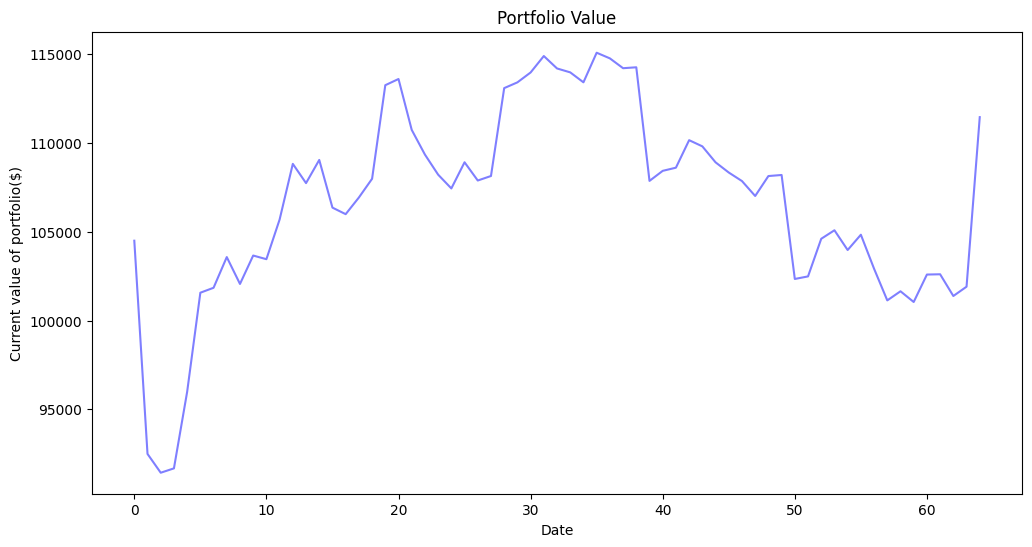

In [80]:
#Plot of Portfolio Returns
plt.figure(figsize=(12,6))
plt.title('Portfolio Value')
plt.plot(Portfolio_value,c='b',alpha=0.5)

plt.ylabel('Current value of portfolio($)')
plt.xlabel('Date')

plt.show()

THE NOTEBOOK ENDS


